# Implementation of EIT susceptibility equations

**2024-03-19** Will Davis and Cameron McGarry

This notebook is used to calculate susceptibility of Rb87 undergoing electromagnetically induced transparency (EIT) for application to the low-loss phase modulation of Davis et al. The S-P-D ladder transition on the D2 line of Rb is considered, but the technique is general and can be applied to various systems by changing the constants used. We are essentially implementing the mathematics of [Gea-Banacloche et al.](https://link.aps.org/doi/10.1103/PhysRevA.51.576)

## A note on notation

We will try and base all of the work here on the notation used in the paper linked above, with the exception that there, the signal is refrred to as the probe, so $p$ subscripts are turned into $s$ for _signal_ in this notebook.

Additionally we note that the absorption coefficient ($\alpha$) is in units of per meter, and goes in the exponent of the Beer-Lambert law ($T = \exp(-\alpha L)$ for transmission ($T$) across a distance ($L$). This is distinct from the _extinction coefficient_ which WD refers to, which is simply $K=-\mathbb{Im}(n)$. There is just a scaling factor so $\alpha\propto K$. This will be introduced where relevant below.

## Setup

Start by doing some importing and defining. I will always put constants and values into their base SI units unless stated otherwise.

Most of the values here can be found either in [Daniel Steck's Rb87 D-line paper](https://steck.us/alkalidata/rubidium87numbers.1.6.pdf) or in [Phys. Rev. Applied 9, 044001](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.9.044001)

I have tried to make the methods below general, so that they can easily be used for different atoms or systems. As such, there are quite a few optional arguments.

As we are trying to deal with Rb87 for now, I have pre-calculated/ defined the pertinent constants. I have used a naming scheme where these typical parameters start with an underscore. So for example the wavelength of the S-P transition is `_wl_s` (`wl` corresponding to wavelength, and `s` to signal).

In [1]:
import numpy as np
from scipy.special import erfcx
import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

# Physical constants
hbar = 6.6e-34 / (2*np.pi)
eps_0 = 8.85e-12 # Permittivity of free space
c = 2.99e8
k_B = 1.38e-23 # Boltzmann constant
m_proton = 1.67e-27 # Proton mass
e = 1.60e-19 # Electron charge
a0 = 5.29e-11 # Bohr radius

# Rb87 atomic structure
m_Rb87 = 87*m_proton # Rb87 mass
_tau2 = 26.24*10**-9 #lifetime of 5P state
_tau3 = 238.5*10**-9 #lifetime of 5D state
_gamma_21 = 1/_tau2
_gamma_31 = 1/_tau3
_wl_s = 780.268e-9 # signal wavelength (from level 1 to 2)
_wl_c = 775.76507e-9 # control wavelength (from level 2 to 3)
_omega_s = 2*np.pi*c/_wl_s # signal angular frequency
_omega_c = 2*np.pi*c/_wl_c # control angular frequency
_d12 = 4.227*e*a0 # Dipole matrix element for 1 to 2
_d23 = 0.991*e*a0 # Dipole matrix element for 2 to 3
_g12 = _d12 / hbar
_g23 = _d23 / hbar

Also from Steck, it is important that we can calculate the number density of the Rb...

In [2]:
_T = 350 # Assume operation at about 80C
def vapour_pressure(T=_T):
    """
    Calculate the vapour pressure in Pa
    Formula from WD code
    """
    torr = 10**(15.88253 - 4529.635/T + 0.00058663*T - 2.99138*np.log10(T))  #vapour pressure in Torr
    return 133.322*torr # conversion to Pa
_P = vapour_pressure()
_N_0 = _P/(k_B*_T)

## Ignoring two photon transition

Start with the condition that we are ignoring the two-photon transition, i.e. we are saying that $\omega_p - \omega_c = 0$. Which is kind of true for our case. It allows us to simplify the maths quite a lot. The pertinent formulae that we will need are (taken directly from the above sources).

The velocity of the atoms from statistical mechanics,

$u = \sqrt{\frac{3 k_B T}{m}}$.

In [3]:
def vel_stat(T=_T, m=m_Rb87):
    """
    Velocity from statistaical mechanics
    Takes temperature (default above) and mass (default is for Rb87)
    """
    return np.sqrt(3*k_B*T/m)
_u = vel_stat() # Save a typical value

The Rabi frequency for the transitions (express the electric field strength in terms of a power $P$ and area $A$)

$|\Omega_{ij}| = \frac{d_{12} E_0}{\hbar} = \frac{d_{ij}}{\hbar}\sqrt{\frac{2P}{cn\epsilon_0 A}}$

where we related the intensity of the light ($I=P/A$) to the electric field strength by $I=cn\epsilon_0E^2/2$ ($n=1$ because this is the light field power ($P$) and area ($A$) in air).

In [4]:
_A = np.pi*(0.1e-3/2)**2 # Typical beam area
_P = 10e-3 # Typical beam power 10mW
def rabi_freq(
    d=_d23,
    P=_P,
    A=_A):
    """
    Default values for the control field with typical parameters
    This returns the amplitude of the Rabi frequency, not the proper complex value
    """
    return (d/hbar)*np.sqrt((2*P)/(eps_0*c*A)) 

The parameter $z$, which will be used to calculate the susceptibility.

$z = \frac{c}{\omega_s u}\left((\gamma_{21} - i\Delta_1) + \frac{\Omega_c^2/4}{\gamma_{31} - i (\Delta_1 +\Delta_2)}\right)$

In [5]:
def z(
    Delta_1,
    Delta_2,
    Omega_c,
    u=_u,
    gamma_21=_gamma_21,
    gamma_31=_gamma_31,
    omega_s = _omega_s,
    ):
    """
    This parameter is defined above
    """
    # Split into three terms for readability, c.f. above formula
    left_term = gamma_21 - 1j*Delta_1
    right_term = 0.25*Omega_c**2/(gamma_31 -1j*(Delta_1 + Delta_2))
    return c*(left_term + right_term) / (omega_s * u)

And of course the susceptibility. Which I have here with a helper function with more useful arguments as well.

$\chi = \frac{4i\hbar g_{21}^2 N_0 \sqrt{\pi}}{\epsilon_0 \left(\frac{\omega_s u}{c}\right)}e^{z^2}\left(1 - \mathrm{erf}(z)\right)$

Here $\mathrm{erf}$ is the error function (and $\mathrm{erfc}(z) = 1 - \mathrm{erf}(z)$). The whole thing is implemented by scipy, so we have $\mathrm{erfcx}(z) = e^{z^2}\left(1 - \mathrm{erf}(z)\right)$.

In [6]:
def susept(
    z,
    g12=_g12,
    omega_s=_omega_s,
    N_0=_N_0,
    u=_u
    ):
    """
    Complex susceptibility
    Takes z parameter, g_21 as the coupling strength between levels 1 and 2, and the angular frequency of the pump beam
    """
    # Split into three terms for readability, c.f. above formula
    num_term = 4j*np.sqrt(np.pi)*hbar*N_0*c*g12**2
    den_term = eps_0*omega_s*u
    final_term = erfcx(z)
    return num_term*final_term / den_term

def suseptt(
    Delta_1,
    Delta_2,
    ctrl_power,
    ):
    """
    Re-implementation of `susept` taking arguments that we care about for initial investigation
    """
    Omega_cs = rabi_freq(P=ctrl_power)
    zs = z(Delta_1, Delta_2, Omega_cs)
    return susept(zs)

Now it's quite simple to start exploring the susceptibility landscape.

We can also start converting from susceptibility into absorption and dispersion: the complex refractive index is $n = \sqrt{1 + \chi}$, and this relates to the absorption (imaginary part) and dispersion (real part) of the vapour.

Absorption coefficient is given by $\alpha = -2 k \mathbb{Im}(n)$, and the accumulated phase over distance $L$ is $\phi = k L \mathbb{Re}(n)$.

These can be used to find the transmission $T=\exp(-\alpha L)$ and phase difference $\Delta\phi = \phi_1 - \phi_2$ for the cases of control on vs. control off.

We can use this to plot the susceptibilities in each case, then reproduce the transmission and phase graph that is used in WD's paper (Fast, low-loss all-optical phase modulation...)

<IPython.core.display.Javascript object>


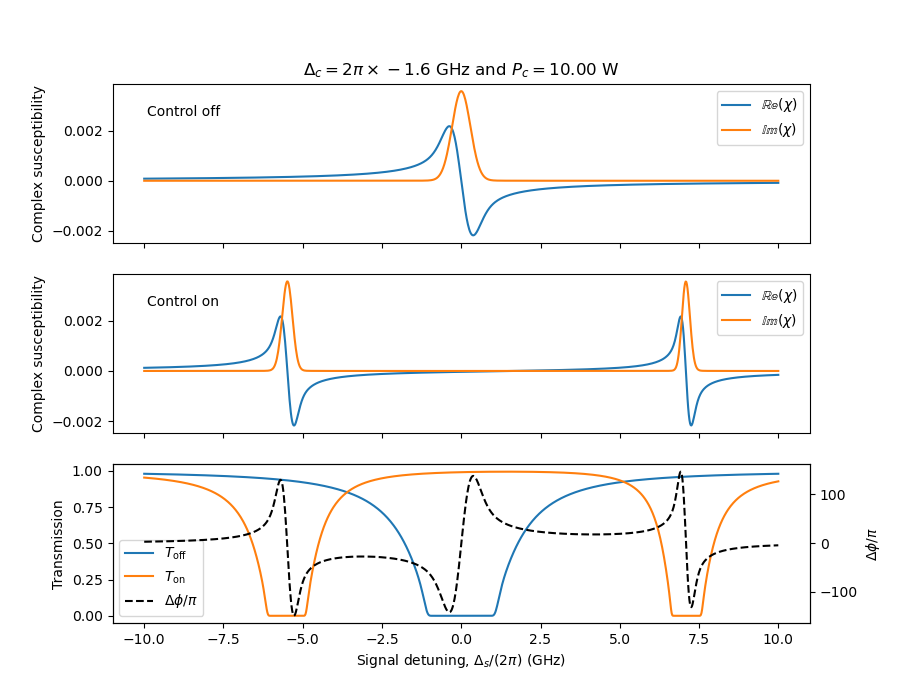

In [22]:
freqs_GHz = np.linspace(-10, 10, 1000)
Delta_1s = 1e9 * 2 * np.pi * freqs_GHz

P_c1 = 10 # Control power
f_c1_GHz = -1.6 # Control detuning in GHz
Delta_c1 = 2*np.pi*1e9*f_c1_GHz
_L = 0.05 # Typical vapour cell 5cm

## Calculate with control off - it is useful to define functions for these because we will use these a lot

def get_propagation_properties(
    Delta_1,
    Delta_2,
    ctrl_power,
    wl_s = _wl_s,
    L = _L
    ):
    """
    Returns the complex suceptibility, refractive index as
    well as the absorption coefficient and accumulated phase for given
    detunings, control power, for a certain signal wavelength and vapour
    cell length
    """
    # Suseceptibility
    chi = suseptt(Delta_1, Delta_2, ctrl_power)
    # Refractive index
    n = np.sqrt(1 + chi)
    # Absorption
    absorp = 4*np.pi*n.imag*L/wl_s
    # Accumulated phase
    phase = 2*np.pi*L*n.real/wl_s
    return chi, n, absorp, phase

chis_off, ns_off, absorps_off, phase_off = get_propagation_properties(Delta_1s, Delta_c1, 0)

## Calculate with control on

chis_on, ns_on, absorps_on, phase_on = get_propagation_properties(Delta_1s, Delta_c1, P_c1)

## Phase difference
phase_diff = (phase_on - phase_off) / np.pi

## Plot

fig, axs = fig, axs = plt.subplots(3, 1, num='Reproduce WD Paper Fig. 1 (b)', figsize=(9,7), sharex=True)

axs[0].plot(freqs_GHz, chis_off.real, label='$\mathbb{Re}(\chi)$')
axs[0].plot(freqs_GHz, chis_off.imag, label='$\mathbb{Im}(\chi)$')
axs[0].legend()
axs[0].set_ylabel('Complex susceptibility')
axs[0].set_title(f'$\Delta_c = 2\pi\\times{f_c1_GHz:.1f}$ GHz and $P_c = {P_c1:.2f}$ W')
axs[0].text(0.05, 0.8, 'Control off', transform=axs[0].transAxes)

axs[1].plot(freqs_GHz, chis_on.real, label='$\mathbb{Re}(\chi)$')
axs[1].plot(freqs_GHz, chis_on.imag, label='$\mathbb{Im}(\chi)$')
axs[1].legend()
axs[1].set_ylabel('Complex susceptibility')
axs[1].text(0.05, 0.8, 'Control on', transform=axs[1].transAxes)

axs[2].plot(freqs_GHz, np.exp(-absorps_off), label='$T_\mathrm{off}$')
axs[2].plot(freqs_GHz, np.exp(-absorps_on), label='$T_\mathrm{on}$')
axs[2].set_ylabel('Transmission')
handles, labels = axs[2].get_legend_handles_labels()

phase_ax = axs[2].twinx()
phase_ax.plot(freqs_GHz, phase_diff, linestyle='dashed', c='k', label='$\Delta\phi/\pi$')
phase_ax.set_ylabel('$\Delta\phi/\pi$')

# Combine legends
handles_main, labels_main = axs[2].get_legend_handles_labels()
handles_twin, labels_twin = phase_ax.get_legend_handles_labels()
axs[2].legend(handles_main + handles_twin, labels_main + labels_twin)

axs[2].set_xlabel('Signal detuning, $\Delta_s / (2\pi)$ (GHz)');

Plotting the two susecptibilities is useful for giving some intutition and comparing to the various plots from WD, TW and others. But the last plot (or something like it) is the one that we typically have used to demonstrate the idea of fast, low(-ish) loss phase modulation.

## Parameter map

We want to find a region where we have high phase modulation as well as high transmission. We can look for this in the CW model. Start with a fixed power, and then vary the detunings. I will just explore this very briefly now to demonstrate the idea.

**Note that the "critical phase" here is just an abritrary value** that I have chosen to produce a clear contour plot. In reality, any area with fairly large phase shift and high transmission is viable, but this should give us an idea of where those areas are.

<IPython.core.display.Javascript object>


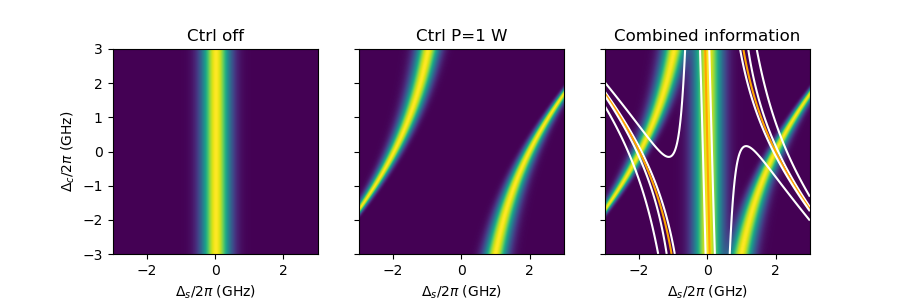

In [8]:
f_s_bot, f_s_top = -3, 3
f_c_bot, f_c_top = -3, 3
f_s = np.linspace(f_s_bot, f_s_top, 1000)
f_c = np.linspace(f_c_bot, f_c_top, 1000)

ff_s, ff_c = np.meshgrid(f_s, f_c)
DD_s = 2*np.pi * 1e9 *ff_s
DD_c = 2*np.pi * 1e9 * ff_c

P_c = 1

# Calculate susceptibilities

chis_off, ns_off, absorps_off, phase_off = get_propagation_properties(DD_s, DD_c, 0)
chis_on, ns_on, absorps_on, phase_on = get_propagation_properties(DD_s, DD_c, P_c)

# Phase difference

Dphi = (phase_on - phase_off)/np.pi

# Plot

phi_crit = 80 # Arbitrary value chosen to make a contour plot clear
clvs = [-phi_crit, 0, phi_crit]

extent = [f_s_bot,f_s_top,f_c_bot,f_c_top]

fig, axs = fig, axs = plt.subplots(1, 3, num='First parameter search', figsize=(9, 3), sharey=True)
col0 = axs[0].imshow(absorps_off, cmap='viridis', extent=extent)
axs[0].set_title('Ctrl off')
axs[0].set_ylabel('$\Delta_c / 2\pi$ (GHz)')

col1 = axs[1].imshow(absorps_on, cmap='viridis', extent=extent)
axs[1].set_title(f'Ctrl P={P_c} W')

col2 = axs[2].imshow((absorps_on + absorps_off)/2, cmap='viridis', extent=extent)
conts = axs[2].contour(Dphi, origin='lower', extent=extent, colors=['white', 'orange','white'], levels=clvs)
#axs[2].clabel(conts)
axs[2].set_title('Combined information')

for i in range(3):
    axs[i].set_xlabel('$\Delta_s/2\pi$ (GHz)')

What we're seeing here is the absorption with the control off (single photon transition, left panel), control on (two photon transition and avoided crossing, central panel) and a combined metric, where we have the mean of the two absorptions in the colour map, as well as the phase contours. We want to be in a low absorption region with large phase shifting, as previously stated. These can be readliy identified in the right-hand plot. However, we are using very high power here, and we haven't accounted for the width of the control pulses, which will result in spectral broadening.

**NOTE** that this 'taking the mean of the absorptions' approach is simply used for ease of illustration, and does not represent a quanitative effect.